# Disf + TBM Segmentation
---
Applying DISF as pre-segmentation method and TBM as superpixel classifier to obtain segmentation on FoxP3+ stained cells.

## Initial Setup

In [1]:
# Necessary Imports
import sys
sys.path.append("../DISF/python3/")
sys.path.append("../iDISF/python3/")
sys.path.append("../")

from idisf import iDISF_scribbles
from disf import DISF_Superpixels
from scripts.segmentation_utils import *
from PIL import Image
from scripts.utils import *
from scripts.superpixel_treatment import *
from ptk_code.utils import *
from ptk_code.TBM_PLOT import batch_PLOT

import datetime
import matplotlib.pyplot as plt
import joblib
import numpy as np
import cv2

/home/gustavo/tcc/TBMCells/ptk_veenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gustavo/tcc/TBMCells/ptk_veenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gustavo/tcc/TBMCells/ptk_veenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gustavo/tcc/TBMCells/ptk_veenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Defining the params for all the pipeline

In [2]:
args = {
    "num_init_seeds":7000,
    "num_final_superpixels":4000,
    "input_img":"2.png",
    "num_of_tries": 5,
    "n_masses": 300
}

## Obtaining Data
---

Opening the input images.

In [3]:
# Opening the 
img = np.array(Image.open(f"../data/cells_dataset/original/{args['input_img']}"), dtype= 'int32');
gt = np.array(Image.open(f"../data/cells_dataset/labels/{args['input_img']}"), dtype = 'int32')

Applying DISF to generate superpixels on the input image as pre-segmentation.

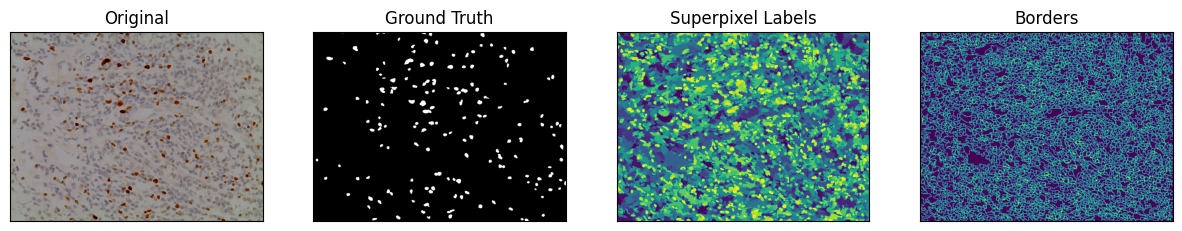

In [4]:
superpixel_label_img, border_img = DISF_Superpixels(img, args['num_init_seeds'], args['num_final_superpixels'])
label_img = superpixel_label_img.copy()
visualize(original = img, ground_truth = gt,  superpixel_labels = superpixel_label_img, borders = border_img)

Loading the pre-trained classifier

In [5]:
# Loading the classifier weights
plot_ns_model = joblib.load('../checkpoints/best.pkl')
plot_ns_model

## Making Predictions
---

In [6]:
def get_positive_ids(predictions, superpixel_indexes):
    """Creating a list with only the positively classified superpixel ids"""
    positive_preds = []
    for i, prediction in enumerate(predictions):
        if prediction == 1:
            positive_preds.append(superpixel_indexes[i])
    return positive_preds

In [7]:
def get_predictions(classifier,input_batch: list[np.array], n_masses:int) -> list[int]:
    """
    Applies the TBM transform and predicts on the dataset
    """
    # Loading the reference dataset
    dataset = 'immuno_cells'
    train_dir = '../data/'+dataset+'/training/'
    (reference_x, y_train) = load_image_data(train_dir)
    # Obtaining the test dataset
    x_input = np.array([np.float64(rgb2gray(datapoint)) for datapoint in input_batch])
    # Applying transform
    batch_plot = batch_PLOT(Nmasses = n_masses)
    x_template=np.mean(reference_x,axis=0)
    reference_x_hat, x_input_hat, Pl_tem, P_tem = batch_plot.forward_seq(reference_x, x_input, x_template)
    # Making predictions
    preds = classifier.predict(x_input_hat)
    return preds

Filtering only the superpixels wich passes on the mean channel threshold. 

In [8]:
def filter_superpixels(ids, superpixels):
    """Applies the superpixel filter by color mean thresholding"""
    filtered_ids= []
    filtered_superpixels = []
    red_channel_mean_threshold = 130 
    green_channel_mean_threshold = 90 
    blue_channel_mean_threshold = 80 
    for id, superpixel in zip(ids, superpixels):
        red_channel_mean = sum(np.unique(superpixel[:,:,0])) / len(np.unique(superpixel[:,:,0]))
        green_channel_mean = sum(np.unique(superpixel[:,:,1])) / len(np.unique(superpixel[:,:,1]))
        blue_channel_mean = sum(np.unique(superpixel[:,:,2])) / len(np.unique(superpixel[:,:,2]))
        if red_channel_mean < red_channel_mean_threshold and  green_channel_mean < green_channel_mean_threshold and blue_channel_mean < blue_channel_mean_threshold:
            filtered_superpixels.append(superpixel)
            filtered_ids.append(id)
    return filtered_ids, filtered_superpixels

In [9]:
# Obtaining the ids of the generated superpixels
superpixel_ids = np.unique(label_img)
superpixel_ids = superpixel_ids[1:] # Excluding the first empty superpixel

segmented_superpixels = []
segmented_superpixels_ids = []


for superpixel_id in superpixel_ids:
    superpixel_img = get_superpixel_img(label_img, superpixel_id)
    cropped_original_img,cropped_superpixel_img = get_cropped_superpixel_img(img, superpixel_img)
    segmented = apply_mask(cropped_original_img, cropped_superpixel_img)
    segmented_superpixels.append(segmented)
    segmented_superpixels_ids.append(superpixel_id)

filtered_ids, filtered_superpixels = filter_superpixels(segmented_superpixels_ids, segmented_superpixels)
classified_superpixels_img = get_reconstructed_image(label_img, filtered_ids)
print(f"{len(filtered_ids)} were filtered to be used to be classified.")

213 were filtered to be used to be classified.


Making predictions on the filtered superpixels, only the positive superpixels (predicted as 1) will be taken into account.

In [10]:
higher_num_of_predictions = 0
positive_ids = []
all_predictions = []
print(f"Predicting {args['num_of_tries']} times.")
for i in range(args['num_of_tries']):
    current_positive_ids = []
    # Obtainig the predictions on the dataset
    predictions = get_predictions(plot_ns_model,filtered_superpixels, args['n_masses'])
    # Obtaining only the ids that were classified positively
    current_positive_ids = get_positive_ids(predictions, filtered_ids)
    print(f"Current iteration predicted superpixels: {len(current_positive_ids)}, previous higher: {higher_num_of_predictions}")
    all_predictions.append(current_positive_ids)
    if len(current_positive_ids) > higher_num_of_predictions:
        higher_num_of_predictions = len(current_positive_ids)
print(f"{higher_num_of_predictions} superpixels were classified as positive cells.")

Predicting 5 times.
Len basis: 30
Current iteration predicted superpixels: 100, previous higher: 0
Len basis: 30
Current iteration predicted superpixels: 213, previous higher: 100
Len basis: 30
Current iteration predicted superpixels: 211, previous higher: 213
Len basis: 30
Current iteration predicted superpixels: 213, previous higher: 213
Len basis: 30
Current iteration predicted superpixels: 175, previous higher: 213
213 superpixels were classified as positive cells.


Reconstructing the image with only the superpixels that were classified as positive

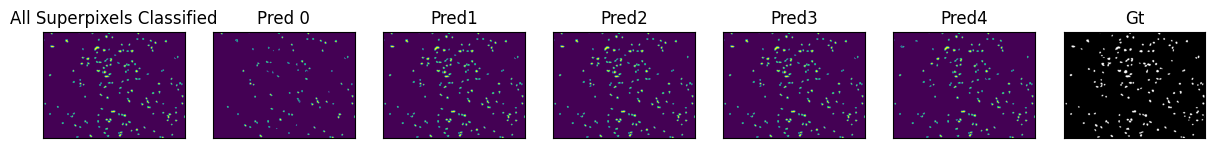

In [11]:
# Visualizing the reconstructed images
reconstructed_imgs = [get_reconstructed_image(label_img, all_predictions[i]) for i in range(len(all_predictions))]
visualize(
    all_superpixels_classified = get_reconstructed_image(label_img, filtered_ids),
    pred_0 = reconstructed_imgs[0],
    pred1 = reconstructed_imgs[1],
    pred2 = reconstructed_imgs[2],
    pred3 = reconstructed_imgs[3],
    pred4 = reconstructed_imgs[4],
    gt = gt
) 

In [12]:
# Visualizing the amount of superpixels predicted
for i, prediction in enumerate(all_predictions):
    print(f"{len(prediction)} superpixels predicted as positive on attempt {i}.")

100 superpixels predicted as positive on attempt 0.
213 superpixels predicted as positive on attempt 1.
211 superpixels predicted as positive on attempt 2.
213 superpixels predicted as positive on attempt 3.
175 superpixels predicted as positive on attempt 4.


## Evaluating the Results
---
Evaluating the predictions that selected the highest amount of superpixels as positive

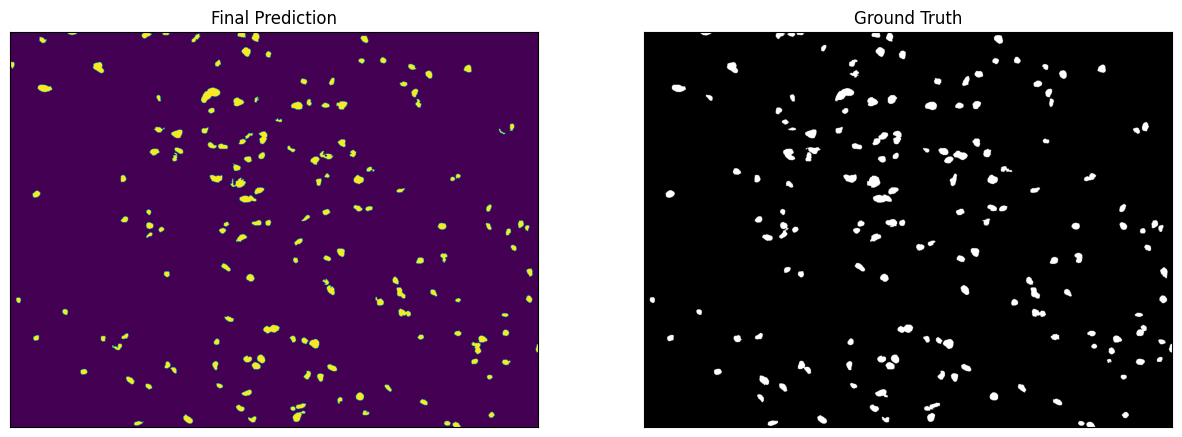

In [13]:
# Obtaining the highest prediction
prediction_amounts = [len(pred) for pred in all_predictions]
final_prediction_img = reconstructed_imgs[prediction_amounts.index(max(prediction_amounts))]
final_prediction_img = np.uint8(final_prediction_img)
visualize(final_prediction = final_prediction_img, ground_truth = gt)

In [14]:
# Converting the ground truth to gray scale
gray_gt = cv2.cvtColor(np.uint8(gt), cv2.COLOR_RGB2GRAY)
print(f"Old shape: {gt.shape}\nNew shape: {gray_gt.shape}")

Old shape: (1532, 2048, 3)
New shape: (1532, 2048)


Obtaining the prediction $\leftrightarrow$ ground truth comparisons:
 - **True Positive**: The objects that were detected detected correctly.
 - **False Negative**: The objects that should be detected but were not.
 - **False Positive**: The objects that shouldn't be detected but were detected as positive.

In [70]:
def apply_open(img, kernel_size = (12,12)):
    """Applies the opening morphological operation on a given image"""
    kernel = np.ones(kernel_size, np.uint8)
    # Aplicar a operação de abertura
    opened_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opened_img

In [71]:
def apply_close(img, kernel_size = (12,12)):
    """Applies the opening morphological operation on a given image"""
    kernel = np.ones(kernel_size, np.uint8)
    # Aplicar a operação de abertura
    opened_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return opened_img

### Obtaining the comparison visualizations. 

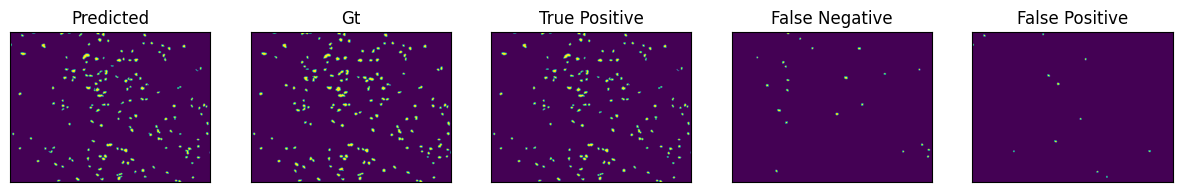

In [106]:
true_positive_img = cv2.bitwise_and(final_prediction_img, gray_gt)
false_negative_img = apply_open(cv2.bitwise_xor(gray_gt, true_positive_img))
false_positive_img = apply_open(cv2.bitwise_xor(final_prediction_img, true_positive_img))
visualize(predicted = final_prediction_img, gt = gray_gt, true_positive= true_positive_img, false_negative = false_negative_img, false_positive = false_positive_img)

The opening morphological operation is applied in order to exclude the objects that were partially segmented objects (already included on true positive count). Let A be the original image and B the morphological kernel, the ``opening`` operation is given by an ``erosion`` operation followed by ``dilation`` as follows:
$$
\text{Opening}(A, B) = (A \ominus B) \oplus B
$$

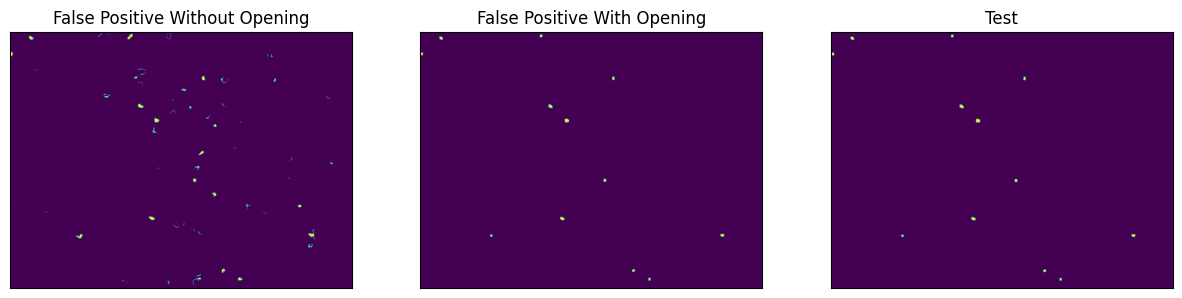

In [107]:
visualize(
    false_positive_without_opening = cv2.bitwise_xor(final_prediction_img, true_positive_img),
    false_positive_with_opening =  false_positive_img,
    test = apply_close(false_positive_img)
)

In [108]:
cv2.connectedComponents(false_positive_img)[0]

13

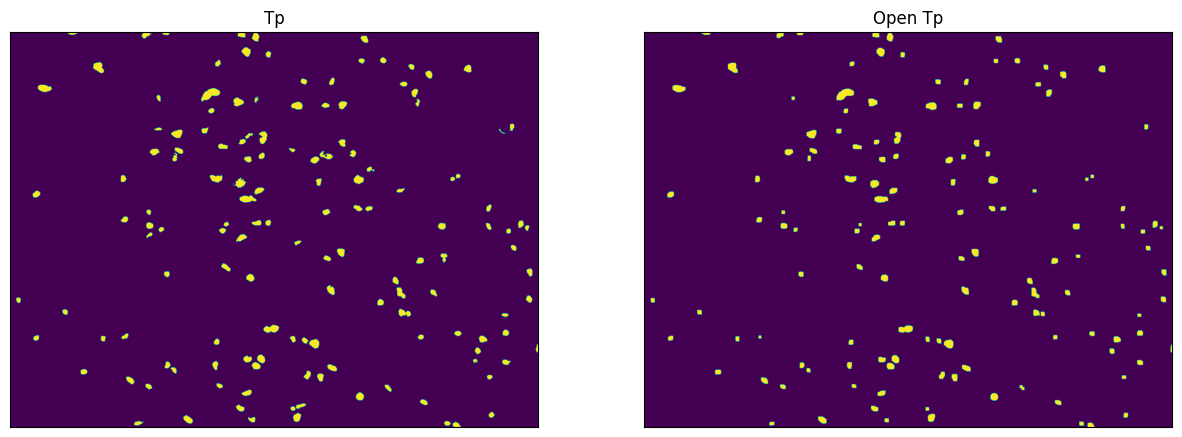

In [109]:
visualize(tp = true_positive_img, open_tp = apply_open(true_positive_img))

In [110]:
cv2.connectedComponents(true_positive_img)[0], cv2.connectedComponents(apply_open(true_positive_img))[0]

(144, 134)

In [112]:
def get_overlap_img(pred, gt):
    """ Creates an overlapped visualization
    bewtween the ground truth and the obtained prediction"""
    pred_arr = np.asarray(pred)
    gt_arr = np.asarray(gt)
    binary_xor = cv2.bitwise_xor(pred_arr, gt_arr)
    return binary_xor

In [113]:
def get_positive_classification_visualization(tp_img, fp_img, ground_truth):
    green = np.array([0, 255, 0])
    blue = np.array([0, 255, 0])
    tp_img_colored = np.int32(change_color(tp_img, green))
    fp_img_colored = np.int32(change_color(fp_img, blue))
    ov_img = get_overlap_img(tp_img_colored, ground_truth)
    ov_img = get_overlap_img(ov_img, fp_img_colored)
    return ov_img

In [122]:
# Obtaining the object count on each image
true_positive =cv2.connectedComponents(apply_open(true_positive_img))[0]
false_negative = cv2.connectedComponents(false_negative_img)[0]
false_positive = cv2.connectedComponents(false_positive_img)[0]
print(f"Amount of obj: {cv2.connectedComponents(gray_gt)[0]}")
print(f"True Positive: {true_positive}")
print(f"False Negative: {false_negative}")
print(f"False Positive: {false_positive}")

Amount of obj: 158
True Positive: 134
False Negative: 23
False Positive: 13


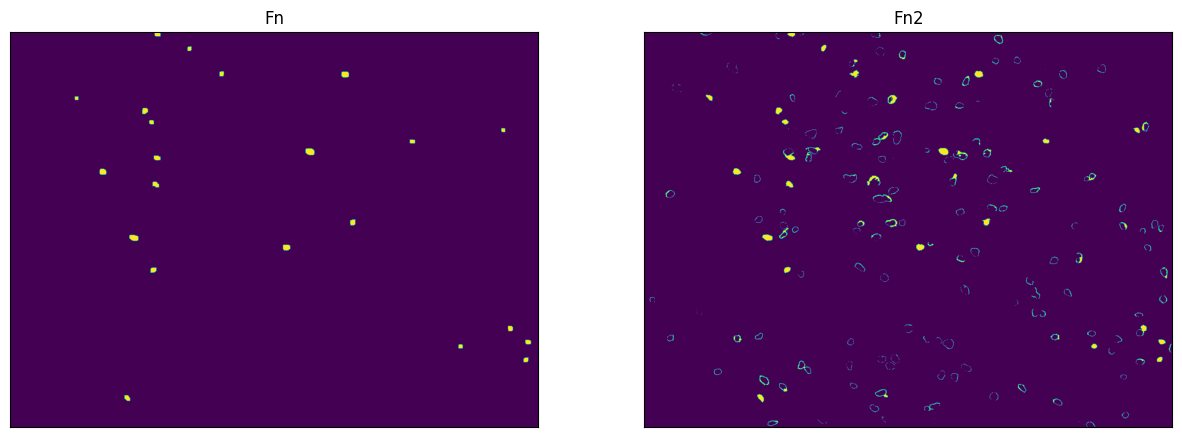

In [115]:
visualize(fn = false_negative_img, fn2 = cv2.bitwise_xor(gray_gt, true_positive_img))

### Qualitative Result

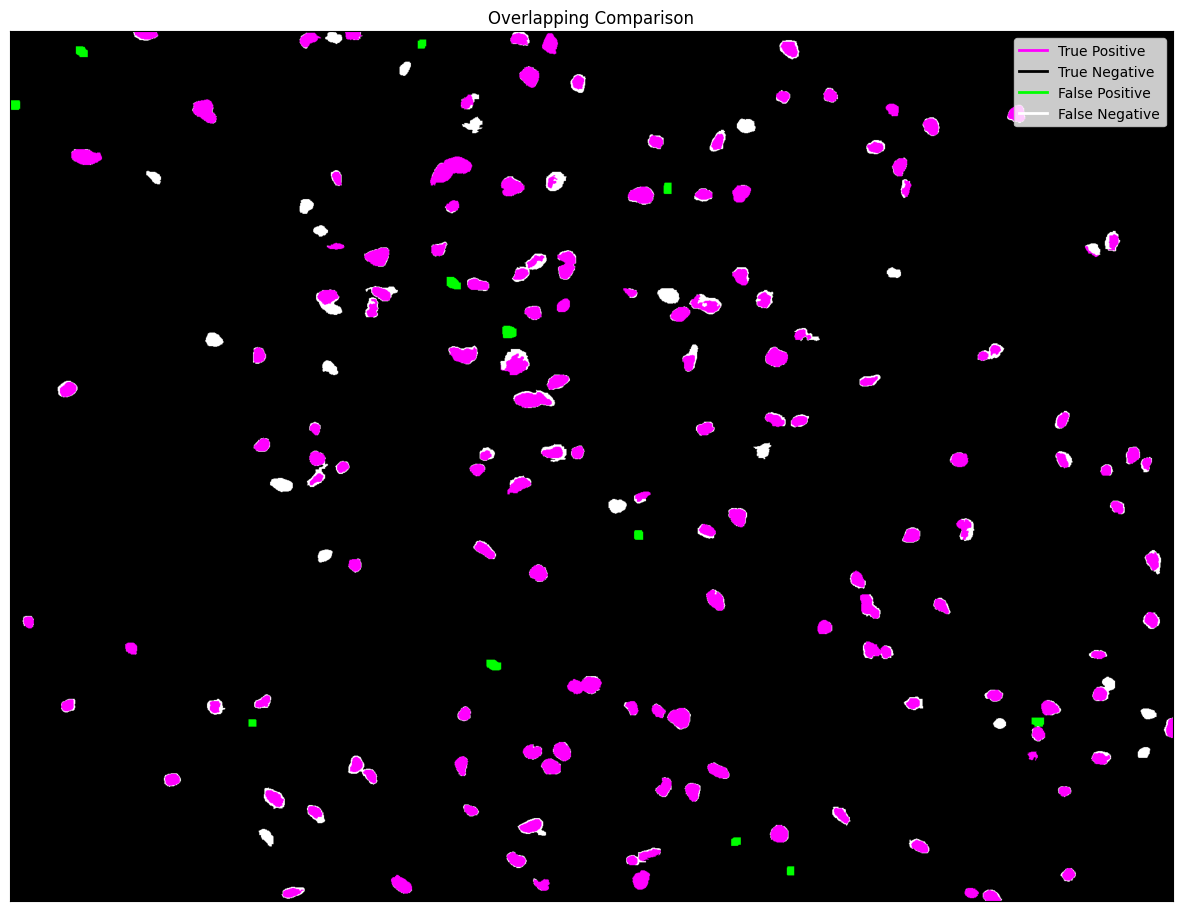

In [116]:
comparison_ovl_img = get_positive_classification_visualization(
    true_positive_img,
    false_positive_img,
    gt
)
overlay_visualize(overlapping_comparison = comparison_ovl_img)

### Quantitative Result
As quantitative evaluation we use the ``precision``, ``recall`` and ``f1-score`` to evaluate the object detection. Let TP be the true positive preditions, FP the false positive and FN the false negative.

In [117]:
from scripts.metrics import calculate_precision, calculate_recall, calculate_f1_score

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$


In [118]:
precision = round(calculate_precision(true_positive, false_positive),2)
precision

0.91

$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

In [119]:
recall = round(calculate_recall(true_positive, false_negative), 2)
recall

0.85

$$\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$


In [120]:
f1_score = round(calculate_f1_score(precision, recall), 2)
f1_score

0.88